<font size="+3"><strong> Predicting Damage with Logistic Regression</strong></font>

# Prepare Data

## Import 

In [20]:
import sqlite3


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

In [21]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")
    
    # Identify Leaky Columns
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    # Create Binary target
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"]= (df["damage_grade"]> 3).astype(int)
    
    # Drop Old Target
    drop_cols.append("damage_grade")
    
    # Drop multicolinearity column
    drop_cols.append("count_floors_pre_eq")
    
    # Drop high cardinality column
    drop_cols.append("building_id")
    
    # Drop Columns
    df.drop(columns=drop_cols, inplace=True)
    
    
    return df


In [24]:
df = wrangle("data/nepal.sqlite")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


In [25]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70836 entries, 164002 to 234835
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            70836 non-null  int64 
 1   plinth_area_sq_ft       70836 non-null  int64 
 2   height_ft_pre_eq        70836 non-null  int64 
 3   land_surface_condition  70836 non-null  object
 4   foundation_type         70836 non-null  object
 5   roof_type               70836 non-null  object
 6   ground_floor_type       70836 non-null  object
 7   other_floor_type        70836 non-null  object
 8   position                70836 non-null  object
 9   plan_configuration      70836 non-null  object
 10  superstructure          70836 non-null  object
 11  severe_damage           70836 non-null  int32 
dtypes: int32(1), int64(3), object(8)
memory usage: 6.8+ MB
None


## Explore

1-Plot a correlation heatmap of the remaining numerical features in `df`. Since `"severe_damage"` will be your target, you don't need to include it in your heatmap. 

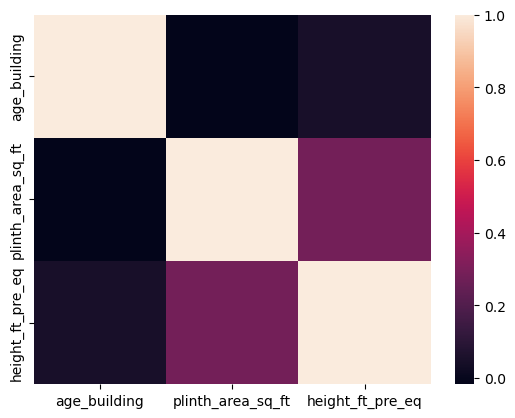

In [26]:
# Create correlation matrix
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr()
correlation
# Plot heatmap of `correlation`
sns.heatmap(correlation);



2-Use seaborn to create a boxplot that shows the distributions of the `"height_ft_pre_eq"` column for both groups in the `"severe_damage"` column. Remember to label your axes

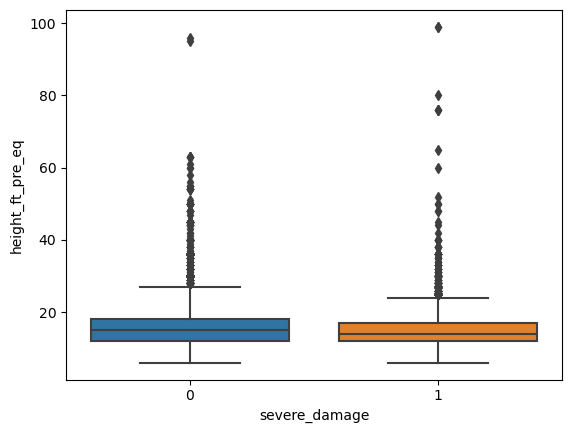

In [29]:
# Create boxplot
sns.boxplot(x="severe_damage",y="height_ft_pre_eq",data =df);




3-Create a bar chart of the value counts for the `"severe_damage"` column. You want to calculate the relative frequencies of the classes, not the raw count, so be sure to set the `normalize` argument to `True`.

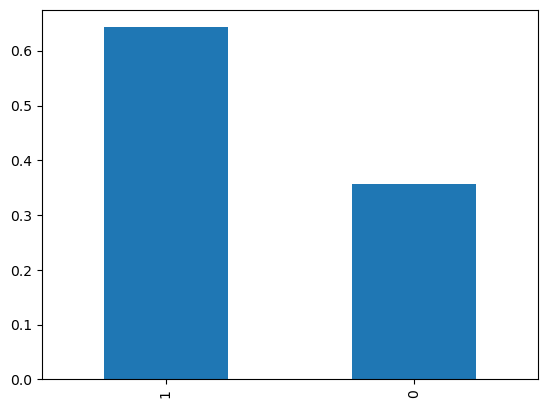

In [30]:
# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar"
);


4-Create two variables, `majority_class_prop` and `minority_class_prop`, to store the normalized value counts for the two classes in `df["severe_damage"]`. 


In [31]:
majority_class_prop, minority_class_prop =df["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.6425969845841097 0.3574030154158902


5-Are buildings with certain foundation types more likely to suffer severe damage? Create a pivot table of `df` where the index is `"foundation_type"` and the values come from the `"severe_damage"` column, aggregated by the mean.

In [32]:
# Create pivot table
foundation_pivot = pd.pivot_table(
    df,index="foundation_type",values="severe_damage",aggfunc=np.mean
).sort_values(by="severe_damage")
foundation_pivot

,severe_damage
foundation_type,
RC,0.026224
Bamboo/Timber,0.324074
Cement-Stone/Brick,0.421908
Mud mortar-Stone/Brick,0.687792
Other,0.818898


6-How do the proportions in `foundation_pivot` compare to the proportions for our majority and minority classes? Plot `foundation_pivot` as horizontal bar chart, adding vertical lines at the values for `majority_class_prop` and `minority_class_prop`.

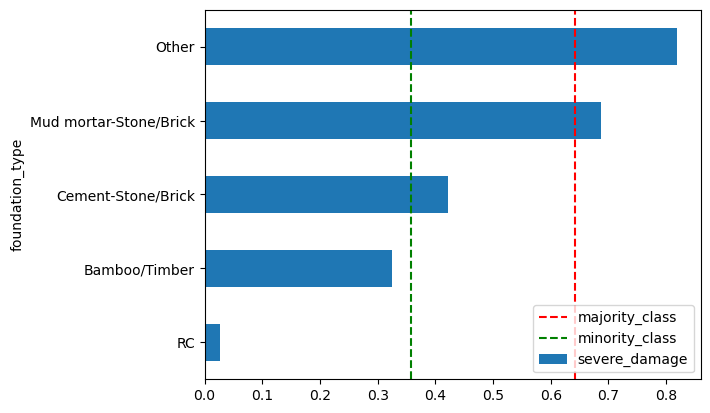

In [36]:
# Plot bar chart of `foundation_pivot`
foundation_pivot.plot(kind="barh")
plt.axvline(
  majority_class_prop , linestyle ="--" ,color ="r",label="majority_class"
)
plt.axvline(
  minority_class_prop , linestyle ="--" ,color ="g",label="minority_class"
)
plt.legend(loc="lower right")


## Split

1-Create your feature matrix `X` and target vector `y`. Your target is `"severe_damage"`. 

In [37]:
target = "severe_damage"

X = df.drop(columns=target)
y = df[target]


2-Divide your data (`X` and `y`) into training and test sets using a randomized train-test split. Your test set should be 20% of your total data. And don't forget to set a `random_state` for reproducibility. 

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (56668, 11)
y_train shape: (56668,)
X_test shape: (14168, 11)
y_test shape: (14168,)


# Build Model

## Baseline

Calculate the baseline accuracy score for your model.

In [40]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.64


## Iterate

Create a pipeline named `model` that contains a `OneHotEncoder` transformer and a `LogisticRegression` predictor. Be sure you set the `use_cat_names` argument for your transformer to `True`. Then fit it to the training data.

In [41]:
# Build model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000))
# Fit model to training data
model.fit(X_train,y_train)


C:\Users\kiro\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

## Evaluate

Calculate the training and test accuracy scores for your models. 

In [42]:
acc_train = accuracy_score(y_train,model.predict(X_train))
acc_test = model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.71
Test Accuracy: 0.72


# Communicate


Instead of using the `predict` method with your model, try `predict_proba` with your training data. How does the `predict_proba` output differ than that of `predict`? What does it represent?

In [43]:
y_train_pred_proba = model.predict_proba(X_train)
print(y_train_pred_proba[:5])

[[0.96558991 0.03441009]
 [0.48126618 0.51873382]
 [0.34905084 0.65094916]
 [0.39661498 0.60338502]
 [0.33508577 0.66491423]]


 Extract the feature names and importances from your `model`.

In [45]:
features = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps["logisticregression"].coef_[0]
